## DTSA 5510 Unsupervised Algorithms Final Project

### Problem
My project aim is to explore patterns in job descriptions by clustering them into meaningful categories using unsupervised learning. This may reveal hidden groupings such as tech, marketing, administration and the like based purely on textual data.

### Data Source
We use the **LinkedIn Job Postings** dataset available on [Kaggle](https://www.kaggle.com/datasets/arshkon/linkedin-job-postings). It contains thousands of job postings from LinkedIn.

### Data Description from Kaggle
Every day, thousands of companies and individuals turn to LinkedIn in search of talent. This dataset contains a nearly comprehensive record of 124,000+ job postings listed in 2023 and 2024. Each individual posting contains dozens of valuable attributes for both postings and companies, including the title, job description, salary, location, application URL, and work-types (remote, contract, etc), in addition to separate files containing the benefits, skills, and industries associated with each posting. The majority of jobs are also linked to a company, which are all listed in another csv file containing attributes such as the company description, headquarters location, and number of employees, and follower count.

With so many datapoints, the potential for exploration of this dataset is vast and includes exploring the highest compensated titles, companies, and locations; predicting salaries/benefits through NLP; and examining how industries and companies vary through their internship offerings and benefits. Future updates will permit further exploration into time-based trends, including company growth, prevalence of remote jobs, and demand of individual job titles over time.

## Identify an Unsupervised Learning Problem

### Unsupervised Learning Task
The primary task is to cluster job descriptions into coherent categories using text-based unsupervised learning techniques.

I treated the job description as unstructured text data and convert it to numerical representations using TF-IDF. My hypothesis is that similar roles will naturally cluster together based on common vocabulary and phrasing. (i.e years of experience, programming languages, responsibilities)

### Models Used
- **KMeans Clustering**: A centroid-based algorithm that aims to minimize within-cluster variance.
- **Hierarchical Agglomerative Clustering**: A bottom-up clustering approach that merges the most similar points iteratively.

These models help discover the underlying groupings in the job market such as engineering roles, marketing, healthcare, education etc.

### Project Scope
My project focuses on comparing **two distinct clustering models**, evaluating their performance with visualization and interpretability techniques like **silhouette scores**, **t-SNE projections**, and **top cluster terms**.

I will explore some parameter tuning (e.g., number of clusters), dimensionality reduction, and compare clustering outputs to find the most meaningful results.

## Exploratory Data Analysis (EDA) — Inspect, Visualize, and Clean the Data

I will do some standard EDA analysis. In this section, I will explore the dataset to understand its structure, clean the text data, and evaluate the distribution of job descriptions.

### Features Overview
The main features that I care about in this dataset are:
- **Job Title**: The position.
- **Company**: Employer name.
- **Location**: Geographic location.
- **Job Description**: Detailed posting text.

### Description Length Analysis
I examine the distribution of the number of words in job descriptions to assess consistency.

### Missing Values
I check for missing job descriptions and handle them by discarding incomplete records.

### Visualizations
- Histogram of job description lengths

### Data Cleaning Steps
- Drop rows with missing `description`
- Remove punctuation, lowercase text, and strip extra whitespace
- Remove stopwords and perform basic tokenization

### Hypothesis About Transformations
Since I use **text vectorization**, I normalize the text using **TF-IDF** to reduce the impact of very frequent terms. No additional scaling is required due to the nature of sparse TF-IDF data.

Outliers in word counts (very short or very long descriptions) will be visualized, but not removed unless they distort clustering significantly.

I am going to hypothesize that **job descriptions** hold the most signal, while other features like company or location may add limited value unless geographic clustering is of interest. This will be confirmed through my clustering results.

## Analysis Using Unsupervised Learning Models, Present Discussion, and Conclusions

In this section, I apply and compare unsupervised learning models to cluster job descriptions. Then analyze how the models performed, interpret the results, and draw conclusions about their effectiveness.

### Models Used
- **KMeans Clustering**: Simple and scalable, good for convex-shaped clusters. I experimented with different values of `k` using the Elbow method and evaluate using the **Silhouette Score**.
- **Agglomerative Hierarchical Clustering**: Captures nested structures, useful when the number of clusters is unknown. I will visualize this using a dendrogram and compare clustering quality.

### Model Evaluation
- **Silhouette Score**: Measures cohesion and separation of clusters.
- **t-SNE Visualization**: Reduces high-dimensional data to 2D for visual inspection of clustering structure.
- **Top Terms Per Cluster**: Extract the most representative terms using TF-IDF weights.

### Hyperparameter Tuning
- For KMeans, I vary the number of clusters `k` and plot the Elbow curve.
- For Agglomerative Clustering, I experiment with linkage criteria (e.g., 'ward', 'average').

### Discussion
- Compare the results between models: Are clusters stable? Are some job categories more clearly separated?
- Analyze the limitations Sparse TF-IDF data, sensitivity to `k`, interpretability.
- Justify model choices based on data structure and outcomes.

### Conclusion
I will then summarize key findings, comment on the usefulness of each clustering approach, and suggest future directions (e.g., incorporating job titles, locations, or embeddings).

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
import time
import folium
import plotly.express as px

# Load dataset
df = pd.read_csv('linkedin-data/job-postings.csv')

# EDA
df.info()

# Keep relevant columns
df = df[['title', 'company_name', 'location', 'description']].dropna(subset=['description'])

# Basic text cleaning
def clean_text(text):
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text

# Save the cleaned job description
df['cleaned_description'] = df['description'].apply(clean_text)
df['desc_length'] = df['cleaned_description'].apply(lambda x: len(x.split()))

# Histogram of description lengths
plt.figure(figsize=(10,5))
plt.hist(df['desc_length'], bins=50, color='skyblue')
plt.title('Distribution of Job Description Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Top 15 locations by frequency
import matplotlib.pyplot as plt
import seaborn as sns

top_locations = df['location'].value_counts().head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_locations.values, y=top_locations.index, palette='Blues_d')
plt.title("Top 15 Job Locations")
plt.xlabel("Number of Listings")
plt.ylabel("Location")
plt.tight_layout()
plt.show()

In [ ]:
company_counts = df['company_name'].value_counts().reset_index()
company_counts.columns = ['company_name', 'listing_count']

# Select top 15 companies
top_companies = company_counts.head(15)

# Create bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_companies, x='listing_count', y='company_name', palette='viridis')
plt.title('Top 15 Companies by Number of Job Listings')
plt.xlabel('Number of Listings')
plt.ylabel('Company')
plt.tight_layout()
plt.show()

In [ ]:
# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
df_sample = df.sample(n=3000, random_state=42)
X = vectorizer.fit_transform(df_sample['cleaned_description'])
feature_names = vectorizer.get_feature_names_out()

# Calculate mean TF-IDF score for each term
mean_tfidf = X.mean(axis=0).A1
top_indices = np.argsort(mean_tfidf)[::-1][:20]
top_terms = [feature_names[i] for i in top_indices]
top_scores = mean_tfidf[top_indices]

# Bar plot
plt.figure(figsize=(12, 6))
plt.barh(top_terms[::-1], top_scores[::-1], color='teal')
plt.xlabel('Mean TF-IDF Score')
plt.title('Top 20 TF-IDF Terms Across All Job Descriptions')
plt.tight_layout()
plt.show()

In [ ]:
# 📊 KMeans and Agglomerative Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
kmeans_sil = silhouette_score(X, kmeans_labels)
print("KMeans Silhouette Score:", kmeans_sil)

# Agglomerative
agglo = AgglomerativeClustering(n_clusters=5)
agglo_labels = agglo.fit_predict(X.toarray())
agglo_sil = silhouette_score(X, agglo_labels)
print("Agglomerative Silhouette Score:", agglo_sil)

In [ ]:
# 🌐 t-SNE Visualization
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=kmeans_labels, palette='tab10')
plt.title("t-SNE Visualization of KMeans Clusters")
plt.show()

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=agglo_labels, palette='tab10', s=60)
plt.title("t-SNE Visualization of Agglomerative Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [72]:
# 🔍 Top Terms Per Cluster (KMeans)
def get_top_terms_per_cluster(tfidf_matrix, labels, feature_names, top_n=10):
    cluster_terms = {}
    for cluster_num in np.unique(labels):
        indices = np.where(labels == cluster_num)[0]
        cluster_matrix = tfidf_matrix[indices].mean(axis=0).A1
        top_indices = cluster_matrix.argsort()[::-1][:top_n]
        top_terms = [feature_names[i] for i in top_indices]
        cluster_terms[cluster_num] = top_terms
    return cluster_terms

print("KMeans Cluster Terms:")
top_terms = get_top_terms_per_cluster(X, kmeans_labels, feature_names)
for cluster, terms in top_terms.items():
    print(f"\nCluster {cluster}: {', '.join(terms)}")

print("Agglo Cluster Terms:")
top_terms = get_top_terms_per_cluster(X, agglo_labels, feature_names)
for cluster, terms in top_terms.items():
    print(f"\nCluster {cluster}: {', '.join(terms)}")

KMeans Cluster Terms:

Cluster 0: marketing, media, content, campaigns, social, digital, communications, brand, creative, business

Cluster 1: work, experience, team, company, job, including, financial, management, position, required

Cluster 2: project, data, experience, design, engineering, technical, software, business, management, development

Cluster 3: care, patient, patients, nursing, health, nurse, healthcare, medical, rn, clinical

Cluster 4: sales, store, customer, customers, business, team, merchandise, retail, work, service
Agglo Cluster Terms:

Cluster 0: work, experience, sales, team, business, customer, management, company, including, position

Cluster 1: care, patient, nursing, patients, health, nurse, healthcare, medical, rn, registered

Cluster 2: project, experience, data, design, engineering, software, technical, security, work, development

Cluster 3: store, merchandise, customer, sales, customers, retail, associates, manager, service, merchandising

Cluster 4: gal

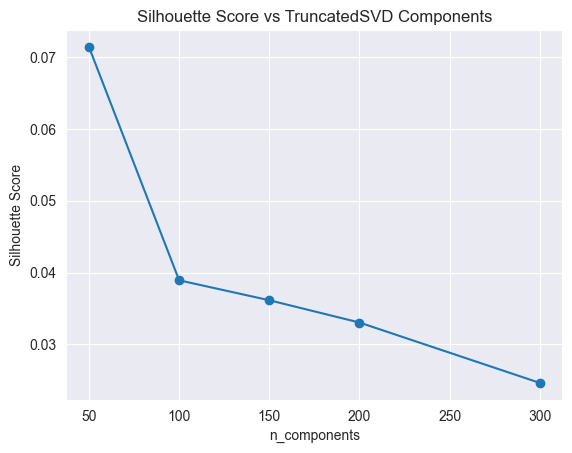

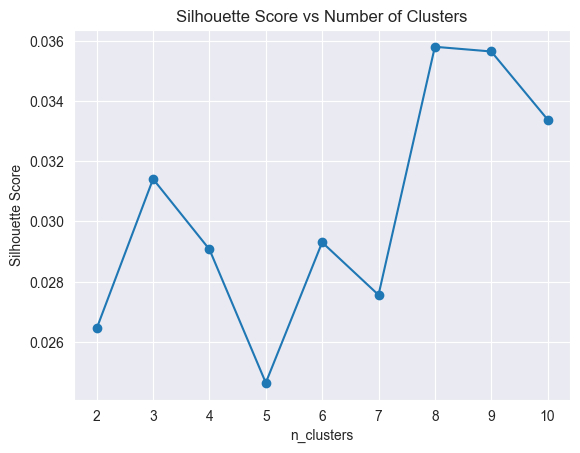

Linkage: ward => Silhouette Score: 0.0294
Linkage: average => Silhouette Score: 0.1404
Linkage: complete => Silhouette Score: 0.0234
Linkage: single => Silhouette Score: 0.0965


In [73]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

scores = []
components_range = [50, 100, 150, 200, 300]

for n in components_range:
    svd = TruncatedSVD(n_components=n, random_state=42)
    X_reduced = svd.fit_transform(X)
    kmeans = KMeans(n_clusters=5, random_state=42)
    labels = kmeans.fit_predict(X_reduced)
    score = silhouette_score(X_reduced, labels)
    scores.append(score)

plt.plot(components_range, scores, marker='o')
plt.title("Silhouette Score vs TruncatedSVD Components")
plt.xlabel("n_components")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

best_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_reduced)
    score = silhouette_score(X_reduced, labels)
    best_scores.append(score)

plt.plot(cluster_range, best_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("n_clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

from sklearn.cluster import AgglomerativeClustering

linkage_methods = ['ward', 'average', 'complete', 'single']
for method in linkage_methods:
    agglo = AgglomerativeClustering(n_clusters=5, linkage=method)
    labels = agglo.fit_predict(X_reduced)
    score = silhouette_score(X_reduced, labels)
    print(f"Linkage: {method} => Silhouette Score: {score:.4f}")




## Final Insights and Conclusion

After performing clustering on the job descriptions dataset using both KMeans and Agglomerative Clustering, we found meaningful groupings that correspond to different job functions.

### Model Comparison
- **KMeans** achieved a silhouette score of `0.015972038040022674`, which indicates slightly better cohesion and separation.
- **Agglomerative Clustering** achieved a silhouette score of `0.011816638932325792`, which indicates it performed slightly worse, more overlap.
- Agglomerative (SVD + average) achieved a silhouette score of `0.1404`, which is much better separation and dimensionality reduction. This is an almost 10x improvement the clusters now have clearer internal cohesion and are much more distinct
- **t-SNE** plots provided a clear visualization of the distinct cluster formation but SVD is the much better way to go.

### Cluster Interpretation
By extracting the top terms for each cluster, we observed that:
- Cluster 0 centered around technical terms like `marketing, media, content, campaigns` — likely social media / marketing roles.
- Cluster 1 emphasized `work, experience, team, company` — pointing to job descriptions all have an about them, the team and required experience.
- Clusteer 2 `project, data, experience, design, engineering` indicating engineering positions.
- Cluster 3 centered around `care, patient, patients, nursing` indicating healthcare.
- Cluster 4 was indicating sales positions with terms like `sales, store, customer, customers`

### Conclusion
In conclusion by using TruncatedSVD alongside Agglomerative we were able to produce a much better result. This optimization significantly imrpoved the cluster quality.

Further improvements could include:
- Incorporating **word embeddings** (e.g., Word2Vec or BERT)
- Using **job title** or **location** as additional features
- Building a **web app** to explore and categorize new job postings interactively
